Having just started learning machine learning and deep learning with the fast.ai course, I wanted to build a small project after finishing lesson 4, as I was starting to feel bored just watching lectures and reading Colab notebooks.

After some research I found that one project to get a strong understanding of how it all works was the MNIST classification project, considered the "Hello, world!" of computer vision.

MNIST is a dataset of handwritten digits developed in 1994 by Yann Lecun, using the works of Corinna Cortes and Chris Burges. It is composed of 60000 digits for the training set, and 10000 digits for the test set.

So the goal of this program is to develop a CNN capable of classifying digits. Truthfully, CNN is actually not needed for this particular task as the images are quite small and centered, we could get good results with a normal neural network. But because CNN is to my understanding state of the art in the computer vision field, I wanted to implement it. To do so, I will proceed in the following steps:

1 - Load the data, preparation if needed

2 - Implement helper functions

3 - Implement the CNN architecture -> trying to do it using OOP as it seems like good practice

4 - Implement the forward pass -> convolution operation, activation using ReLU, max pooling, repeating, flattening, FC layer using softmax.

5 - Implement Backprop using SGD (need more details on that)

6 - Implement the training loop, with the number of epochs as a parameter (forward pass -> compute loss -> backward pass -> update params)

7 - Get results, test accuracy

8 - Optimization

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy.signal import convolve2d
import skimage.measure
from scipy.special import softmax

First, we load the MNIST dataset downloaded from Kaggle (https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data).

To do so, we use the struct module (https://stackoverflow.com/a/53181925) : the first 8 bytes contain the magic number, used to identify the file type, and the size of the dataset. The next 8 bytes contain the number of rows and the number of columns (28x28).

struct.unpack(">II", ...) unpacks these bytes into two 32-bit integers (">II" means big-endian, two unsigned ints).

TRAINING SET LABEL FILE (train-labels-idx1-ubyte):

[offset] [type]          [value]          [description]

0000     32 bit integer  0x00000801(2049) magic number (MSB first)

0004     32 bit integer  60000            number of items

0008     unsigned byte   ??               label

0009     unsigned byte   ??               label

........

xxxx     unsigned byte   ??               label

The labels values are 0 to 9.

TRAINING SET IMAGE FILE (train-images-idx3-ubyte):

[offset] [type]          [value]          [description]

0000     32 bit integer  0x00000803(2051) magic number

0004     32 bit integer  60000            number of images

0008     32 bit integer  28               number of rows

0012     32 bit integer  28               number of columns

0016     unsigned byte   ??               pixel

0017     unsigned byte   ??               pixel

........

xxxx     unsigned byte   ??               pixel

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


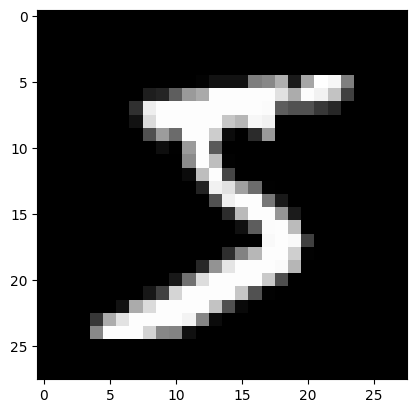

In [48]:
with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    train_data = data.reshape((size, nrows, ncols))

with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    print(train_labels)

with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    test_data = data.reshape((size, nrows, ncols))

with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    print(test_labels)

plt.imshow(train_data[0],  cmap='gray')
plt.show()

First, we need to define some helper functions.
apply_convolution uses convolve2d of scipy to convolve the image and the kernel.
max_pooling uses skimage to pool the image with the pool_size passed as a param.

In [3]:
def apply_convolution(image, kernel, bias):
    return convolve2d(image, kernel, mode='valid') + bias

def max_pooling(image, pool_size=(2,2)):
    return skimage.measure.block_reduce(image, pool_size, np.max)

def cross_entropy(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred))

Next, we will build the architecture of our model in OOP.

While working on this, a question arised: what is the difference between adding layers of convolution and adding filters per layer of convolution? How can I choose if I do one or the other? Well, adding layers of convolution typically means increasing the depth of the neural network which allows for learning more complex and abstract features of the image. On the other hand, increasing the number of filters of a convolution layer allows for learning more features at the same level of abstraction. The first has a greater impact on computational complexity.
Adding more layers : Helpful when dealing with more complex patterns or larger input sizes
Adding more filters per layer : Helpful to capture more diverse features at a particular level of abstraction

In [65]:
class ConvLayer:

    # nb: could add stride
    def __init__(self, num_filters, kernel_size):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        #parameters
        self.W = None
        self.b = None

    def initialize(self, input_depth):
        self.W = np.random.randn(self.num_filters, self.kernel_size, self.kernel_size, input_depth) / (self.kernel_size * self.kernel_size) # divide xavier initialization
        self.b = np.zeros(self.num_filters)

    def forward(self, X):
        if self.W is None:
            self.initialize(X.shape[-1]) #initialize if not done already with the input depth as parameter

        new_size = X.shape[0] - self.W.shape[1] + 1 # the size of the output after the convolution : current size - kernel size + 1
        
        new_depth = self.W.shape[3]*self.W.shape[0] # the depth of the output after the convolution : current depth * number of filters
        
        output = np.zeros((new_size,new_size,new_depth)) # output matrix initialization

        updated_i = 0

        #apply conv for each image with each filter
        for i_X in range(self.W.shape[3]):
            for i_W in range(self.W.shape[0]):
                output[:,:,updated_i] = convolve2d(X[:,:,i_X], self.W[i_W,:,:,i_X], mode="valid") + self.b[i_W]
                updated_i+=1

        return output

    def backward(self):
        


        

class MaxPoolingLayer:

    def __init__(self, pool_size):
        self.pool_size = pool_size

    def forward(self, X):
        size = X.shape[0]
        depth = X.shape[2]
        
        output = np.zeros((size//2, size//2, depth))

        for i in range(depth):
            output[:,:,i] = X[:size//self.pool_size*self.pool_size, :size//self.pool_size*self.pool_size, i].reshape(size//self.pool_size, self.pool_size, size//self.pool_size, self.pool_size).max(axis=(1,3))

        return output
        
           

class FCLayer:

    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.W = None
        self.b = None

    def initialize(self):
        self.W = np.random.randn(self.input_size, self.output_size) * np.sqrt(2.0 / self.input_size) # using HE-Initialization
        self.b = np.zeros(self.output_size)

    def forward(self, X):
        if self.W is None:
            self.initialize()
        X = np.dot(X, self.W) + self.b

        return X
        

class CNN:

    def __init__(self):

        self.layers = []
        
        #self.conv_layers = conv_layers
        #self.fc_layers_sizes = fc_layers_sizes
        #self.fc_layers = []

    def new_layer(self, layer):
        self.layers.append(layer)


"""
    def forward_pass(self, X):
        for i, layer in enumerate(self.conv_layers, 1):
            if layer.W is None:
                layer.initialize(X.shape[-1])
            X = self.convolution(X, layer)
            X = np.maximum(X, 0)  # ReLU
            X = self.max_pool(X)
            print(f"Layer {i} output shape: {X.shape}")      

        X = X.flatten()

        input_size = X.shape[0]

        # Creates each fc layers according to the fc_layers_sizes (including the output size, in this case: 10)
        for i in range(0, len(self.fc_layers_sizes)):
            output_size = self.fc_layers_sizes[i]
            self.fc_layers.append(FCLayer(input_size, output_size))
            input_size = output_size

        for i, layer in enumerate(self.fc_layers):
            if layer.W is None:
                layer.initialize()
            X = np.dot(X, layer.W) + layer.b
            if i == len(self.fc_layers)-1:
                
                X = softmax(X)
            else:
                X = np.maximum(X, 0)  # ReLU
            
        return X

    # For the convolution, I chose to use scipy.signal.convolve2d as it is implemented and compiled in C
    # which makes it much faster to operate than if I implemented it myself in python (and it's quite easier too...) 
    def convolution(self, X, layer):

        #example :
        #X : (28,28,1)
        #layer.W : (3,3,3,1)
        #output : (26, 26, 3)

        #next iteration :
        #X : (26,26,3)
        #layer.W : (3,3,3,3)
        #output : (24,24,9)
        
        X[:,:,0] extracts the 2D image from the 3D array.
        layer.W[i,:,:,0] selects the i-th 3x3 filter.
        The 'valid' mode in convolve2d ensures the correct output size.
        might need to squeeze or reshape the convolve2d output to fit into the output array.

        new_size = X.shape[0] - layer.W.shape[1] + 1
        
        new_depth = layer.W.shape[3]*layer.W.shape[0]
        
        output = np.zeros((new_size,new_size,new_depth))

        updated_i = 0
        
        for i_X in range(layer.W.shape[3]):
            for i_W in range(layer.W.shape[0]):
                output[:,:,updated_i] = convolve2d(X[:,:,i_X], layer.W[i_W,:,:,i_X], mode="valid") + layer.b[i_W]
                updated_i+=1

        return output
        
        
    def max_pool(self, X, pool_size=2):

        size = X.shape[0]
        depth = X.shape[2]
        
        output = np.zeros((size//2, size//2, depth))

        for i in range(depth):
            output[:,:,i] = X[:size//pool_size*pool_size, :size//pool_size*pool_size, i].reshape(size//pool_size, pool_size, size//pool_size, pool_size).max(axis=(1,3))

        return output

    def backward(self, output, learning_rate):
        #kernel_gradient = np.zeros(
        pass
"""


#cnn = CNN([256,256,10], ConvLayer(3, 3), ConvLayer(1,2))
cnn = CNN()
cnn.new_layer(ConvLayer(3,3))
cnn.new_layer(MaxPoolingLayer(2))
cnn.new_layer(FCLayer(507, 256))
cnn.new_layer(FCLayer(256, 10))

train_data = train_data.reshape(60000,28,28,1)

X = cnn.layers[0].forward(train_data[0])
X = cnn.layers[1].forward(X)
X = np.maximum(X, 0)
X = X.flatten()
X = cnn.layers[2].forward(X)
X = np.maximum(X, 0)
X = cnn.layers[3].forward(X)
X = softmax(X)
print(X)

print(X.shape)

#sample_output = cnn.forward_pass(train_data[0])


[1.07934370e-19 1.33907912e-09 1.90458045e-29 3.60512194e-34
 5.53681595e-47 2.21036925e-33 1.06071620e-34 1.83825247e-05
 2.27240531e-31 9.99981616e-01]
(10,)


At this point, we achieved the first part of the project. The forward pass allows the model to properly arrive to a conclusion. For now, the result is quite bad due to the randomness of the parameters.

Now we need to implement backpropagation to allow the model to learn by computing the loss and updating the weights and biases accordingly.

My first idea to get the loss was to compute the difference between the actual number and the confidence for each number. For example:
Let's say the actual number is a 2 and the output we got is this [0.09982253 0.10030541 0.1006628  0.09944194 0.09963454 0.10006153
  0.10002742 0.10004489 0.09985413 0.10014481] -> the model predicted a 7

What we would do is first create an array of size 10 for the actual number with zeros for each index not of that number and a one for the right index : [0 0 1 0 0 0 0 0 0 0]

Then we would compute the absolute difference between each value to get the loss for this particular prediction. We would repeat the process for all the 60000 predictions.

After some testing, I noticed that the program was really slow to compute the absolute difference for each of the inputs. I then did some research and found out that my solution, while valid, was really slow and was not really commonly used. After some research, I came accross this the Cross Entropy Loss function which is the default loss function to use for multi-class classification problems.

So that's what we will use for the loss.

In [22]:
print("Output for first image:", sample_output)
print("Predicted class:", np.argmax(sample_output))
print("Actual class:", train_labels[0])

loss = cross_entropy(np.eye(10)[train_labels[0]], sample_output)

print("Cross Entropy Loss :", loss)

Output for first image: [1.29864598e-04 6.01580449e-03 9.17749047e-05 3.08605719e-02
 6.56884428e-04 8.11295365e-06 9.62171078e-01 3.58716986e-07
 1.84767927e-09 6.55483964e-05]
Predicted class: 6
Actual class: 5
Cross Entropy Loss : 1.1722048557608111


In [48]:


all_outputs = np.array([forward_pass(img) for img in train_data[:1000]])

results = np.argmax(all_outputs, axis=-1).T

print("Accuracy over all train dataset:", np.mean(results == train_labels[:1000]))

Accuracy over all train dataset: 0.105


In [49]:
def cross_entropy(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred))

loss = cross_entropy(np.eye(10)[train_labels], all_outputs)

print(loss)

"""
arr = np.zeros(10)
arr[train_labels[0]] = 1
arr = np.eye(10)[train_labels[0]]

loss = abs(np.eye(10)[train_labels] - all_outputs)

print(loss)
"""

0.2302550384901763


'\narr = np.zeros(10)\narr[train_labels[0]] = 1\narr = np.eye(10)[train_labels[0]]\n\nloss = abs(np.eye(10)[train_labels] - all_outputs)\n\nprint(loss)\n'